In [2]:
# Cell 1: Imports (add these if missing)
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Dataset path
dataset_path = r'D:\F_Y_P\dataset_blood_group'
img_size = (224, 224)  # MobileNetV2 works best with 224x224
batch_size = 32

In [3]:
# Cell 2: Data Generators (Strong Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(train_generator.class_indices)  # Save this for Flask!

Found 4803 images belonging to 8 classes.
Found 1197 images belonging to 8 classes.
{'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}


In [4]:
# Cell 3: Build Model with Transfer Learning (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,047,240 (11.62 MB)

 Trainable params: 789,256 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Cell 4: Phase 1 - Train Only Top Layers (10-20 epochs)
callbacks_phase1 = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-7),
    ModelCheckpoint('best_head_model.h5', save_best_only=True)
]

history_phase1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks_phase1
)

d:\F_Y_P\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1998 - loss: 2.2203

151/151 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.2451 - loss: 1.9748 - val_accuracy: 0.3617 - val_loss: 1.6433 - learning_rate: 0.0010
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3153 - loss: 1.7139

151/151 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.3223 - loss: 1.7097 - val_accuracy: 0.3793 - val_loss: 1.5534 - learning_rate: 0.0010
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3531 - loss: 1.6312

151/151 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.3423 - loss: 1.6384 - val_accuracy: 0.3901 - val_loss: 1.5520 - learning_rate: 0.0010
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3523 - loss: 1.6012

151/151 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.3608 - loss: 1.5850 - val_accuracy: 0.4002 - val_loss: 1.4581 - learning_rate: 0.0010
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.3862 - loss: 1.5344 - val_accuracy: 0.4002 - val_loss: 1.4597 - learning_rate: 0.0010
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3753 - loss: 1.5489

151/151 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.3900 - loss: 1.5249 - val_accuracy: 0.4344 - val_loss: 1.4147 - learning_rate: 0.0010
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3904 - loss: 1.5084

151/151 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.3975 - loss: 1.4961 - val_accuracy: 0.4386 - val_loss: 1.4107 - learning_rate: 0.0010
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3943 - loss: 1.4866

151/151 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.3935 - loss: 1.4834 - val_accuracy: 0.4470 - val_loss: 1.4089 - learning_rate: 0.0010
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.3916 - loss: 1.4833 - val_accuracy: 0.4244 - val_loss: 1.4288 - learning_rate: 0.0010
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4240 - loss: 1.4863

151/151 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.4245 - loss: 1.4665 - val_accuracy: 0.4211 - val_loss: 1.3938 - learning_rate: 0.0010
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3971 - loss: 1.4630

151/151 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.4087 - loss: 1.4546 - val_accuracy: 0.4553 - val_loss: 1.3555 - learning_rate: 0.0010
Epoch 12/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.4222 - loss: 1.4325 - val_accuracy: 0.4503 - val_loss: 1.3596 - learning_rate: 0.0010
Epoch 13/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.4256 - loss: 1.4078 - val_accuracy: 0.4603 - val_loss: 1.3764 - learning_rate: 0.0010
Epoch 14/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4161 - loss: 1.4258

151/151 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.4264 - loss: 1.4064 - val_accuracy: 0.4695 - val_loss: 1.3203 - learning_rate: 0.0010
Epoch 15/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.4310 - loss: 1.3939 - val_accuracy: 0.4595 - val_loss: 1.3479 - learning_rate: 0.0010
Epoch 16/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.4499 - loss: 1.3741 - val_accuracy: 0.4545 - val_loss: 1.3377 - learning_rate: 0.0010
Epoch 17/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4323 - loss: 1.4355

151/151 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.4403 - loss: 1.4131 - val_accuracy: 0.4879 - val_loss: 1.3018 - learning_rate: 0.0010
Epoch 18/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.4464 - loss: 1.3708 - val_accuracy: 0.4628 - val_loss: 1.3103 - learning_rate: 0.0010
Epoch 19/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4563 - loss: 1.3607

151/151 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.4508 - loss: 1.3678 - val_accuracy: 0.4862 - val_loss: 1.2776 - learning_rate: 0.0010
Epoch 20/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.4495 - loss: 1.3895 - val_accuracy: 0.4837 - val_loss: 1.2981 - learning_rate: 0.0010


In [6]:
# Cell 5: Phase 2 - Fine-Tune with Low LR
# Unfreeze last 20-30 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with MUCH lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Critical: 100x smaller!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_phase2 = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-7),
    ModelCheckpoint('best_finetuned_model.h5', save_best_only=True)
]

history_phase2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks_phase2
)

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3023 - loss: 1.9526

151/151 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.3392 - loss: 1.7756 - val_accuracy: 0.4085 - val_loss: 1.5485 - learning_rate: 1.0000e-05
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3998 - loss: 1.5437

151/151 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.4068 - loss: 1.5176 - val_accuracy: 0.4327 - val_loss: 1.4806 - learning_rate: 1.0000e-05
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4207 - loss: 1.4734

151/151 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.4195 - loss: 1.4701 - val_accuracy: 0.4586 - val_loss: 1.3346 - learning_rate: 1.0000e-05
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.4439 - loss: 1.4055 - val_accuracy: 0.4578 - val_loss: 1.3503 - learning_rate: 1.0000e-05
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4287 - loss: 1.4058

151/151 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.4474 - loss: 1.3800 - val_accuracy: 0.4720 - val_loss: 1.3186 - learning_rate: 1.0000e-05
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4509 - loss: 1.3860

151/151 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.4620 - loss: 1.3554 - val_accuracy: 0.4737 - val_loss: 1.2857 - learning_rate: 1.0000e-05
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4822 - loss: 1.3317

151/151 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.4814 - loss: 1.3209 - val_accuracy: 0.4854 - val_loss: 1.2529 - learning_rate: 1.0000e-05
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4664 - loss: 1.3122

151/151 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.4776 - loss: 1.2976 - val_accuracy: 0.5330 - val_loss: 1.2428 - learning_rate: 1.0000e-05
Epoch 9/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4946 - loss: 1.3034

151/151 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.4995 - loss: 1.2786 - val_accuracy: 0.5071 - val_loss: 1.1994 - learning_rate: 1.0000e-05
Epoch 10/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4948 - loss: 1.2704

151/151 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.4966 - loss: 1.2671 - val_accuracy: 0.5380 - val_loss: 1.1843 - learning_rate: 1.0000e-05
Epoch 11/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.5041 - loss: 1.2548 - val_accuracy: 0.5347 - val_loss: 1.1879 - learning_rate: 1.0000e-05
Epoch 12/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5112 - loss: 1.2306

151/151 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.5055 - loss: 1.2408 - val_accuracy: 0.5305 - val_loss: 1.1810 - learning_rate: 1.0000e-05
Epoch 13/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5215 - loss: 1.2194

151/151 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.5290 - loss: 1.2068 - val_accuracy: 0.5380 - val_loss: 1.1665 - learning_rate: 1.0000e-05
Epoch 14/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5255 - loss: 1.1958

151/151 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.5272 - loss: 1.2102 - val_accuracy: 0.5414 - val_loss: 1.1497 - learning_rate: 1.0000e-05
Epoch 15/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.5199 - loss: 1.1979 - val_accuracy: 0.5547 - val_loss: 1.1511 - learning_rate: 1.0000e-05
Epoch 16/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5365 - loss: 1.1911

151/151 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.5399 - loss: 1.1855 - val_accuracy: 0.5764 - val_loss: 1.1058 - learning_rate: 1.0000e-05
Epoch 17/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.5276 - loss: 1.1647 - val_accuracy: 0.5505 - val_loss: 1.1251 - learning_rate: 1.0000e-05
Epoch 18/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5364 - loss: 1.1548

151/151 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5478 - loss: 1.1432 - val_accuracy: 0.6048 - val_loss: 1.0637 - learning_rate: 1.0000e-05
Epoch 19/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.5463 - loss: 1.1492 - val_accuracy: 0.5806 - val_loss: 1.0848 - learning_rate: 1.0000e-05
Epoch 20/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5500 - loss: 1.1217

151/151 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.5536 - loss: 1.1202 - val_accuracy: 0.5965 - val_loss: 1.0360 - learning_rate: 1.0000e-05
Epoch 21/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.5692 - loss: 1.1191 - val_accuracy: 0.5898 - val_loss: 1.0532 - learning_rate: 1.0000e-05
Epoch 22/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.5653 - loss: 1.1191 - val_accuracy: 0.5990 - val_loss: 1.0494 - learning_rate: 1.0000e-05
Epoch 23/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5736 - loss: 1.0994 - val_accuracy: 0.6065 - val_loss: 1.0440 - learning_rate: 1.0000e-05
Epoch 24/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5716 - loss: 1.0907

151/151 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.5721 - loss: 1.0925 - val_accuracy: 0.6324 - val_loss: 1.0072 - learning_rate: 1.0000e-05
Epoch 25/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5976 - loss: 1.0662

151/151 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.5932 - loss: 1.0651 - val_accuracy: 0.6199 - val_loss: 1.0055 - learning_rate: 1.0000e-05
Epoch 26/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5677 - loss: 1.0880

151/151 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.5759 - loss: 1.0831 - val_accuracy: 0.6282 - val_loss: 0.9934 - learning_rate: 1.0000e-05
Epoch 27/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6008 - loss: 1.0239

151/151 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5965 - loss: 1.0388 - val_accuracy: 0.6374 - val_loss: 0.9749 - learning_rate: 1.0000e-05
Epoch 28/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.5984 - loss: 1.0382 - val_accuracy: 0.6124 - val_loss: 0.9957 - learning_rate: 1.0000e-05
Epoch 29/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6130 - loss: 1.0416 - val_accuracy: 0.6307 - val_loss: 0.9849 - learning_rate: 1.0000e-05
Epoch 30/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5947 - loss: 1.0595

151/151 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.6040 - loss: 1.0345 - val_accuracy: 0.6307 - val_loss: 0.9620 - learning_rate: 1.0000e-05


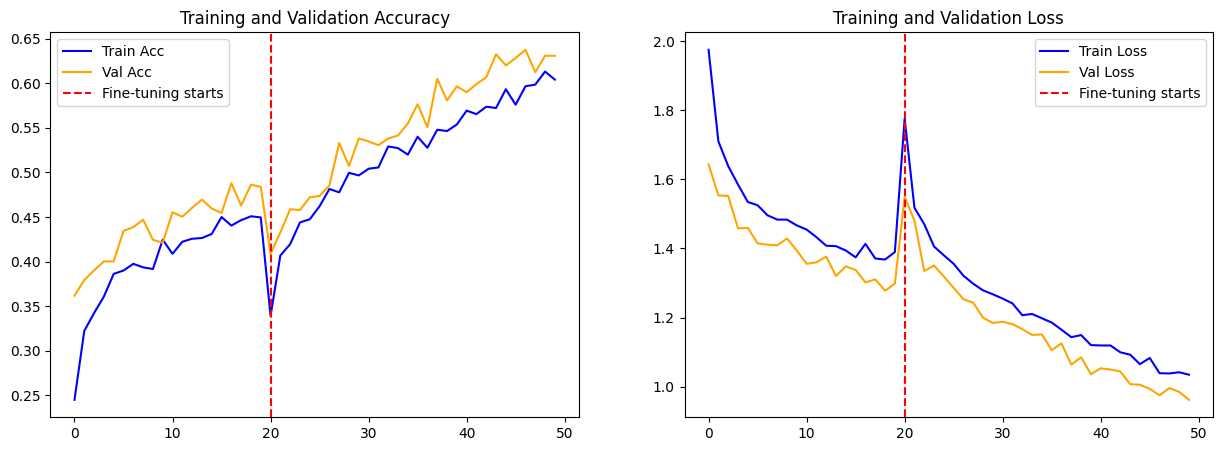

In [7]:
# Cell 6: Plot Results
def plot_history(history1, history2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history1.history['accuracy'] + history2.history['accuracy'], label='Train Acc', color='blue')
    ax1.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='Val Acc', color='orange')
    ax1.axvline(len(history1.history['accuracy']), color='red', linestyle='--', label='Fine-tuning starts')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history1.history['loss'] + history2.history['loss'], label='Train Loss', color='blue')
    ax2.plot(history1.history['val_loss'] + history2.history['val_loss'], label='Val Loss', color='orange')
    ax2.axvline(len(history1.history['accuracy']), color='red', linestyle='--', label='Fine-tuning starts')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    
    plt.show()

plot_history(history_phase1, history_phase2)

In [8]:
# Cell 7: Save Final Model
model.save('blood_group_model_final.h5')
print("Model saved! Use this in your Flask app.")

Model saved! Use this in your Flask app.
